In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# show all columns
pd.set_option('display.max_columns', None)

from sklearn.preprocessing import StandardScaler
from mlxtend.plotting import scatterplotmatrix, heatmap

In [2]:
import utils

In [3]:
# reload th imports
import importlib
importlib.reload(utils)

<module 'utils' from '/Users/sophiechance/Documents/Cal/Github/foster_care_analysis/utils.py'>

# Import Data

In [4]:
# 2001 codebook
variable_values_2001_df = pd.read_excel('raw_data/DS101 FC2001v5/Data/Metadata & Text Files/FC Variable Values.xlsx') # Used for mapping
variables_2001_df = pd.read_excel('raw_data/DS101 FC2001v5/Data/Metadata & Text Files/FC Variables.xlsx') # Explains what the variables are

In [5]:
var_name = 'SSIOTHER'
variables_2001_df[variables_2001_df['VarName'] == var_name]

,VarName,VarLabel,Start,Length,Columns,Type
71,SSIOTHER,SSI Or Social Security Act Benefits,113,1,113,INTEGER1


In [6]:
variable_values_2001_df[variable_values_2001_df['VarName'] == var_name]

,VarName,Value,ValueLabel
306,SSIOTHER,0,No
307,SSIOTHER,1,Yes


In [7]:
raw_df_2001 = pd.read_sas('raw_data/DS101 FC2001v5/Data/SAS files/fc01v5f.sas7bdat') # Main data file
raw_df_2002 = pd.read_csv('raw_data/DS105 FC2002v8/Data/Text Files/FC2002v8.tab', sep='\t', lineterminator='\n') # Main data file
raw_df_2003 = pd.read_sas('raw_data/DS118 FC2003v7/Data/SAS Files/FC03v7f.sas7bdat') # Main data file

/var/folders/x4/dl28z_rx30n4bp144tvcf38m0000gn/T/ipykernel_88040/3689710240.py:2: DtypeWarning: Columns (7,103) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_df_2002 = pd.read_csv('raw_data/DS105 FC2002v8/Data/Text Files/FC2002v8.tab', sep='\t', lineterminator='\n') # Main data file


In [8]:
df_2001 = utils.make_readable(raw_df_2001, variable_values_2001_df)
df_2002 = utils.make_readable(raw_df_2002.rename({'FY':'DataYear', 'FIPSCode':'FIPSCODE'}, axis=1), variable_values_2001_df)
df_2003 = utils.make_readable(raw_df_2003.rename({'FY':'DataYear', 'FIPSCode':'FIPSCODE'}, axis=1), variable_values_2001_df)

# Concatenate Dataframes

In [9]:
# all_records = pd.concat([df_2001, df_2002, df_2003], axis=0)
all_records = df_2001.reset_index() # temporarily doing 2001 only so that the code runs faster
print(all_records.shape)

(813283, 67)


# Clean up NaN values

In [10]:
# columns_before = set(all_records.columns)
# all_records.dropna(thresh=0.2*len(all_records), axis=1, inplace=True) # Drop columns with more than 20% NaNs
# columns_after = set(all_records.columns)
# print(columns_before - columns_after)
all_records.dropna(thresh=0.5*len(all_records.columns), axis=0, inplace=True) # Drop rows with more than 50% NaNs

print(all_records.shape)

(748224, 67)


In [12]:
# Clean up NaNs
# Payment Columns
all_records['FCMntPay'] = all_records['FCMntPay'].replace(np.nan, 0).astype(float) # Assumed that if null then they are not getting paid
all_records['IVEFC'] = all_records['IVEFC'].replace(np.nan, 0).astype(float) # Assumed that if null then they are not getting paid
all_records['IVAAFDC'] = all_records['IVAAFDC'].replace(np.nan, 0).astype(float) # Assumed that if null then they are not getting paid

# Length of Stay Columns
all_records['PreviousLOS'] = all_records['PreviousLOS'].replace(np.nan, 0).astype(float) # Replace NaNs with 0 because it means they have no previous LOS
all_records['LifeLOS'] = all_records['LifeLOS'].replace(np.nan, 0).astype(float) # Replace NaNs with 0, if this is null, it is their first placement
all_records['SettingLOS'] = all_records['SettingLOS'].replace(np.nan, 0).astype(float) # Replace NaNs with 0 # TODO: Not sure if this is an accurate represnetation, need to look into this more

# Placement
all_records['TOTALREM'] = all_records['TOTALREM'].replace(np.nan, 1).astype(float) # Assume first removal, all records with null have a value of 0 in PreviousLOS
all_records['NUMPLEP'] = all_records['NUMPLEP'].replace(np.nan, 1).astype(float) # Assume 1 placement if null

# Default to no for these columns # TODO - Decide if this is the best way to handle these
nan_to_0_cols = ['VISHEAR', 'PHYDIS', 'MR', 'OTHERMED', 'DSMIII', 'RELINQSH', 'HOUSING', 'PRTSDIED', 'PRTSJAIL', 'CHILDIS', 'DACHILD', 'AACHILD', 'ABANDMNT', 'CHBEHPRB', 'NOCOPE', 'DAPARENT', 'AAPARENT', 'SEXABUSE', 'PHYABUSE', 'IVDCHSUP', 'NOA', 'IVEAA', 'XIXMEDCD', 'IVAAFDC', 'NEGLECT', 'SSIOTHER']
all_records[nan_to_0_cols] = all_records[nan_to_0_cols].fillna(0)

# Replace NaNs with 'DNG' (Data Not Given) for these columns - seperate from Unknown
nan_to_dng_cols = ['currentPlacementSetting', 'dischargeReason', 'fosterFamilyStructure', 'everAdopted', 'caretakerFamilyStructure', 'diagnosedDisability', 'OutOfStatePlacement', 'removalManner', 'caseGoal', 'FIPSCode', 'Sex']
all_records[nan_to_dng_cols] = all_records[nan_to_dng_cols].fillna('DNG')

# Drop any rows where the id did not come in properly # TODO: Investigate why this is happening
print(f"Records with a bad ID: {len(all_records[all_records['RecNumbr'].str.contains('[a-zA-Z]', na=False)])}")
all_records = all_records[~all_records['RecNumbr'].str.contains('[a-zA-Z]', na=False)]

all_records.drop(columns=['secondCaretakerAge', 
                          'secondFosterCaretakerAge', 
                          'firstFosterCaretakerAge',
                          'firstCaretakerAge',
                        #   'RU13\r', # Not needed, Rural Urban Continuum Code, only included in 2002
                        #   'Race', # Not needed, incorperated into other columns (one hot encoding style), only included in 2002
                          'LatRemLOS', # column seems repetitive in nature
                          ], inplace=True)

# Drop records where RecNumbr is unknown
all_records = all_records[all_records['RecNumbr'] == all_records['RecNumbr']] # Drop records where RecNumbr is unknown
print(f"RecNumbr Unknown: {len(all_records[all_records['RecNumbr'] != all_records['RecNumbr']])}")

# Drop records where age is unknown
all_records['AgeAtStart'] = all_records['AgeAtStart'].fillna(99) # some are blank and some are 99, entry error
all_records = all_records[all_records['AgeAtStart'] != 99]
print(f"Age Unknown: {len(all_records[all_records['AgeAtStart'] == 99])}\n")

# Final Stats
print(f"Total Null Values: {all_records.isnull().sum().sum()}")
print(f"Total Records: {len(all_records)}")
print(f"Total Columns: {len(all_records.columns)}")

Records with a bad ID: 0
RecNumbr Unknown: 0
Age Unknown: 0

Total Null Values: 0
Total Records: 479526
Total Columns: 62


In [13]:
# all_records.isnull().sum().sort_values(ascending=False).head(20)

# Filtering Data
Filter for only records that have 
1. Exited the system
2. Are older than 18 years old in 2021
3. dischargeReason is known

In [14]:
# overwriting all records here to save memory - previously named: included_subset
all_records = all_records[(all_records['Exited'] == 1) & (all_records['age2021'] >= 18) & (all_records['dischargeReason'] != 'DNG')].reset_index(drop=True)
print(f"Total Records: {len(all_records)}")

Total Records: 150732


# One Hot Encoding

In [15]:
ml_df = pd.get_dummies(all_records, drop_first=True)

(<Figure size 1000x600 with 25 Axes>,
 array([[<Axes: xlabel='AgeAtStart', ylabel='Count'>, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >],
        [<Axes: xlabel='LifeLOS', ylabel='AgeAtStart'>,
         <Axes: xlabel='LifeLOS', ylabel='Count'>, <Axes: >, <Axes: >,
         <Axes: >],
        [<Axes: xlabel='FCMntPay', ylabel='AgeAtStart'>,
         <Axes: xlabel='FCMntPay', ylabel='LifeLOS'>,
         <Axes: xlabel='FCMntPay', ylabel='Count'>, <Axes: >, <Axes: >],
        [<Axes: xlabel='Race', ylabel='AgeAtStart'>,
         <Axes: xlabel='Race', ylabel='LifeLOS'>,
         <Axes: xlabel='Race', ylabel='FCMntPay'>,
         <Axes: xlabel='Race', ylabel='Count'>, <Axes: >],
        [<Axes: xlabel='firstCaretakerAge', ylabel='AgeAtStart'>,
         <Axes: xlabel='firstCaretakerAge', ylabel='LifeLOS'>,
         <Axes: xlabel='firstCaretakerAge', ylabel='FCMntPay'>,
         <Axes: xlabel='firstCaretakerAge', ylabel='Race'>,
         <Axes: xlabel='firstCaretakerAge', ylabel='Count'>]]

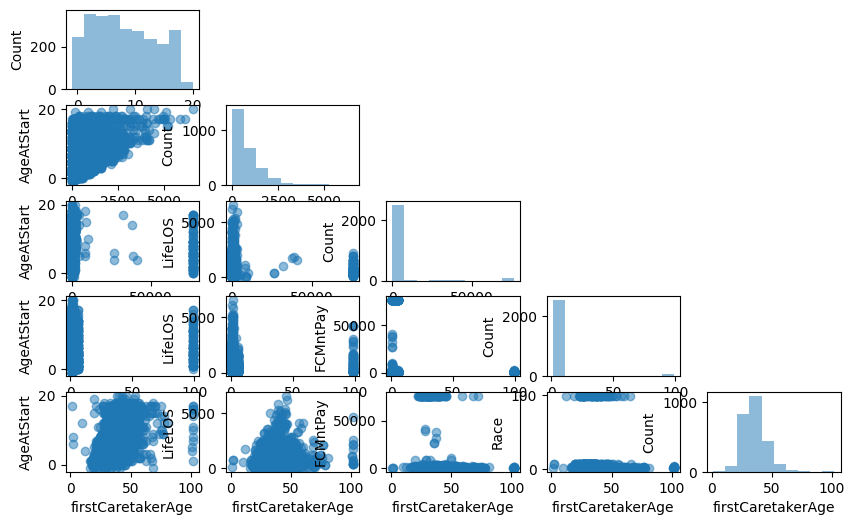

In [85]:
cols = ['AgeAtStart', 'LifeLOS', 'FCMntPay', 'Race', 'firstCaretakerAge']
scatterplotmatrix(all_records[cols].values, figsize=(10, 6), names=cols, alpha=0.5)

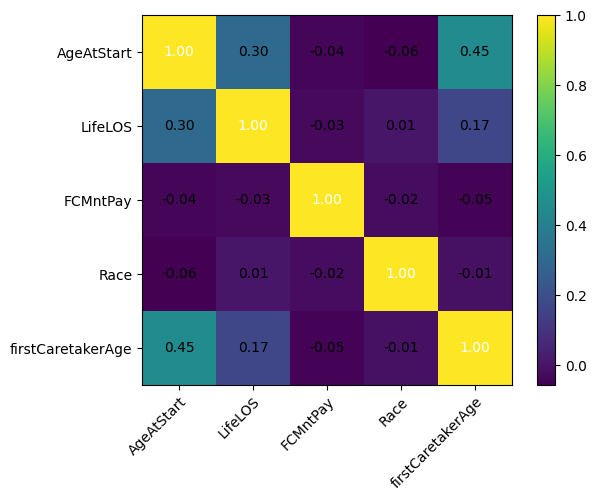

In [86]:
cm = np.corrcoef(included_subset[cols].values.T)
hm = heatmap(cm, row_names=cols, column_names=cols)
plt.show()

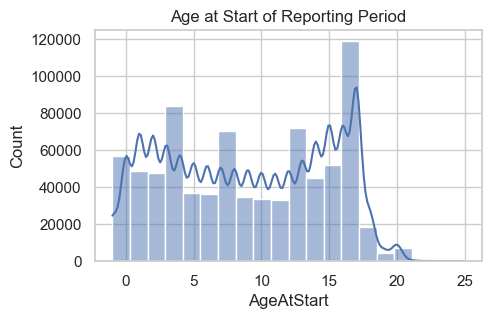

In [82]:
# plot the distribution of the ages
sns.set(style="whitegrid")
plt.figure(figsize=(5, 3))
sns.histplot(included_subset['AgeAtStart'].where(included_subset['AgeAtStart'] < 26 , np.nan), kde=True, bins=20)
plt.title('Age at Start of Reporting Period')
plt.show()

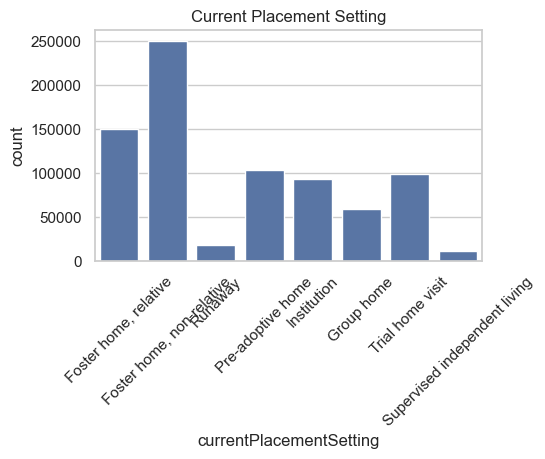

In [91]:
# plot the current placement setting
plt.figure(figsize=(5, 3))
sns.countplot(data=included_subset, x='currentPlacementSetting')
plt.title('Current Placement Setting')
plt.xticks(rotation=45)
plt.show()

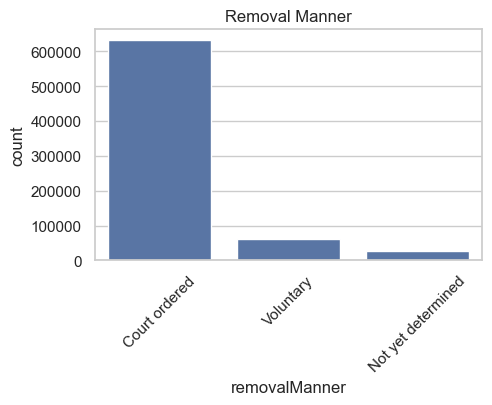

In [93]:
# plot the current placement setting
plt.figure(figsize=(5, 3))
sns.countplot(data=included_subset, x='removalManner')
plt.title('Removal Manner')
plt.xticks(rotation=45)
plt.show()

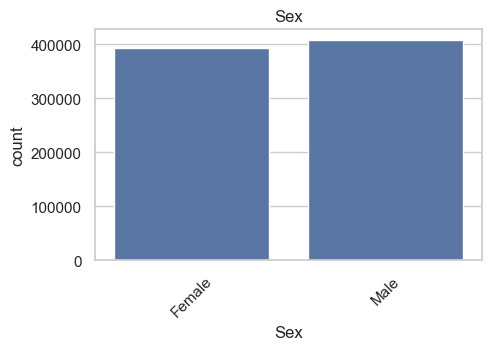

In [102]:
plt.figure(figsize=(5, 3))
sns.countplot(data=included_subset, x='Sex')
plt.title('Sex')
plt.xticks(rotation=45)
plt.show()

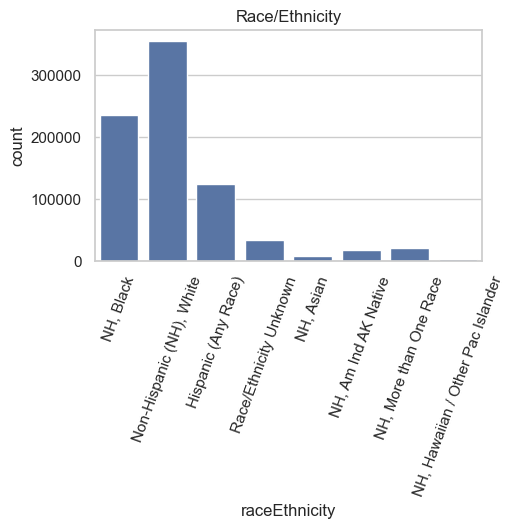

In [95]:
plt.figure(figsize=(5, 3))
sns.countplot(data=included_subset, x='raceEthnicity')
plt.title('Race/Ethnicity')
plt.xticks(rotation=70)
plt.show()

In [101]:
included_subset.groupby('State')['RecNumbr'].count().sort_values(ascending=False) #.plot(kind='bar', figsize=(5, 3))

State
California              126281
Florida                  55671
New York                 52431
Ohio                     39272
Pennsylvania             36280
Minnesota                27162
Michigan                 26970
Georgia                  26293
Texas                    24506
Illinois                 22547
Washington               18742
Missouri                 18600
Colorado                 18197
Oklahoma                 17877
Massachusetts            17404
Iowa                     17078
North Carolina           15707
Wisconsin                15174
New Jersey               15142
Tennessee                14642
Arizona                  14303
Indiana                  13612
Oregon                   12974
Kentucky                 12542
Arkansas                  9511
South Carolina            9473
Louisiana                 9046
Maryland                  8946
Nevada                    8906
Nebraska                  8201
Alabama                   7447
Virginia                  6862
Ha

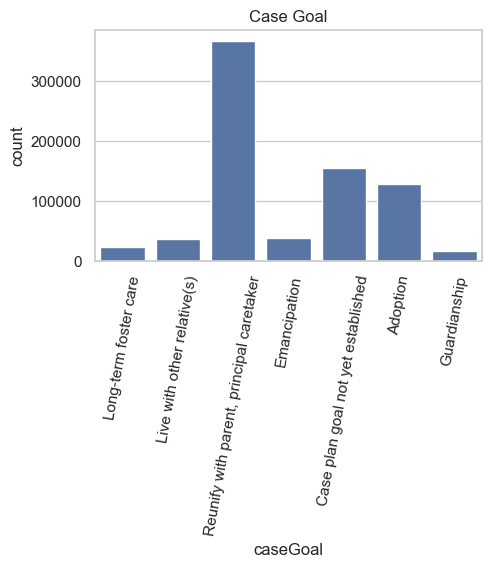

In [99]:
plt.figure(figsize=(5, 3))
sns.countplot(data=included_subset, x='caseGoal')
plt.title('Case Goal')
plt.xticks(rotation=80)
plt.show()

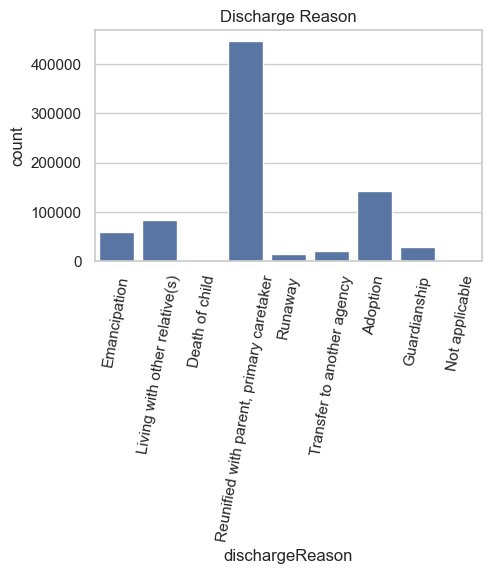

In [100]:
plt.figure(figsize=(5, 3))
sns.countplot(data=included_subset[included_subset['Exited'] == 1], x='dischargeReason')
plt.title('Discharge Reason')
plt.xticks(rotation=80)
plt.show()

# Defining Success in Foster Care

Intention: Predict the likelihood of a child successfully being reunified with their parent.

- dischargeReason = Reunified with parent, primary caretaker
- Does not enter the system a second time before the age of 18.

#### Entering the System Again
In order to successfully measure this we need to:
1. Calculate the age of each exited ['Exited' = 1] child relative to 2021 (the last year of reporting) and make sure it is at least 18.
2. Check to see if these children appear again in the data set after their exit date.
3. If child never appears again in the data set and their age is above 18 by 2021, they are considered to have successfully exited the system.

### Subquestions
- What is the likelihood of a child who has been reunified with their parent entering the system again?